# Customer Churn Prediction

This work aims to predict customer churn using supervised learning techniques.

## Setup

In [1]:
# Install and import libs

!pip install shap
!pip install imblearn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import shap
import numpy as np

## Load Data

In [2]:
# Load data
data = pd.read_csv('./data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Exploratory Data Analysis

In [3]:
print("=> Dataset info:")
print(data.info())

=> Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 no

In [4]:
print("\n=> Descriptive statistics:")
print(data.describe())


=> Descriptive statistics:
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


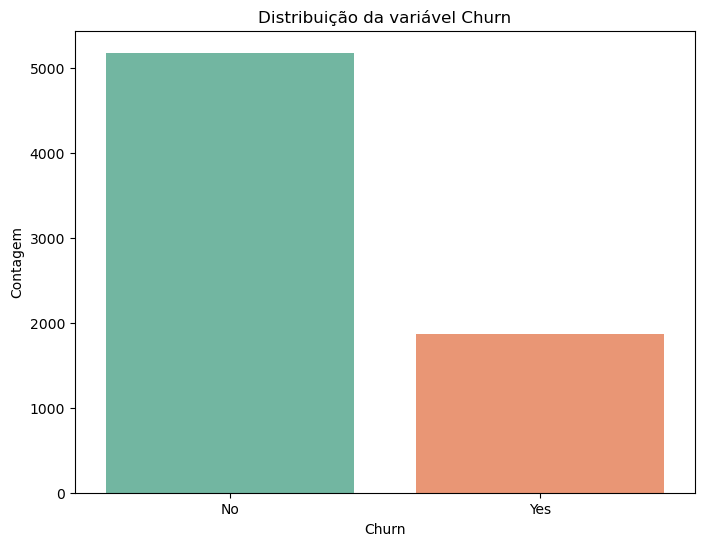

In [5]:
# Analysis of the target variable balance (Churn)
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=data, hue='Churn', palette='Set2', legend=False)
plt.title('Distribuição da variável Churn')
plt.xlabel('Churn')
plt.ylabel('Contagem')
plt.show()

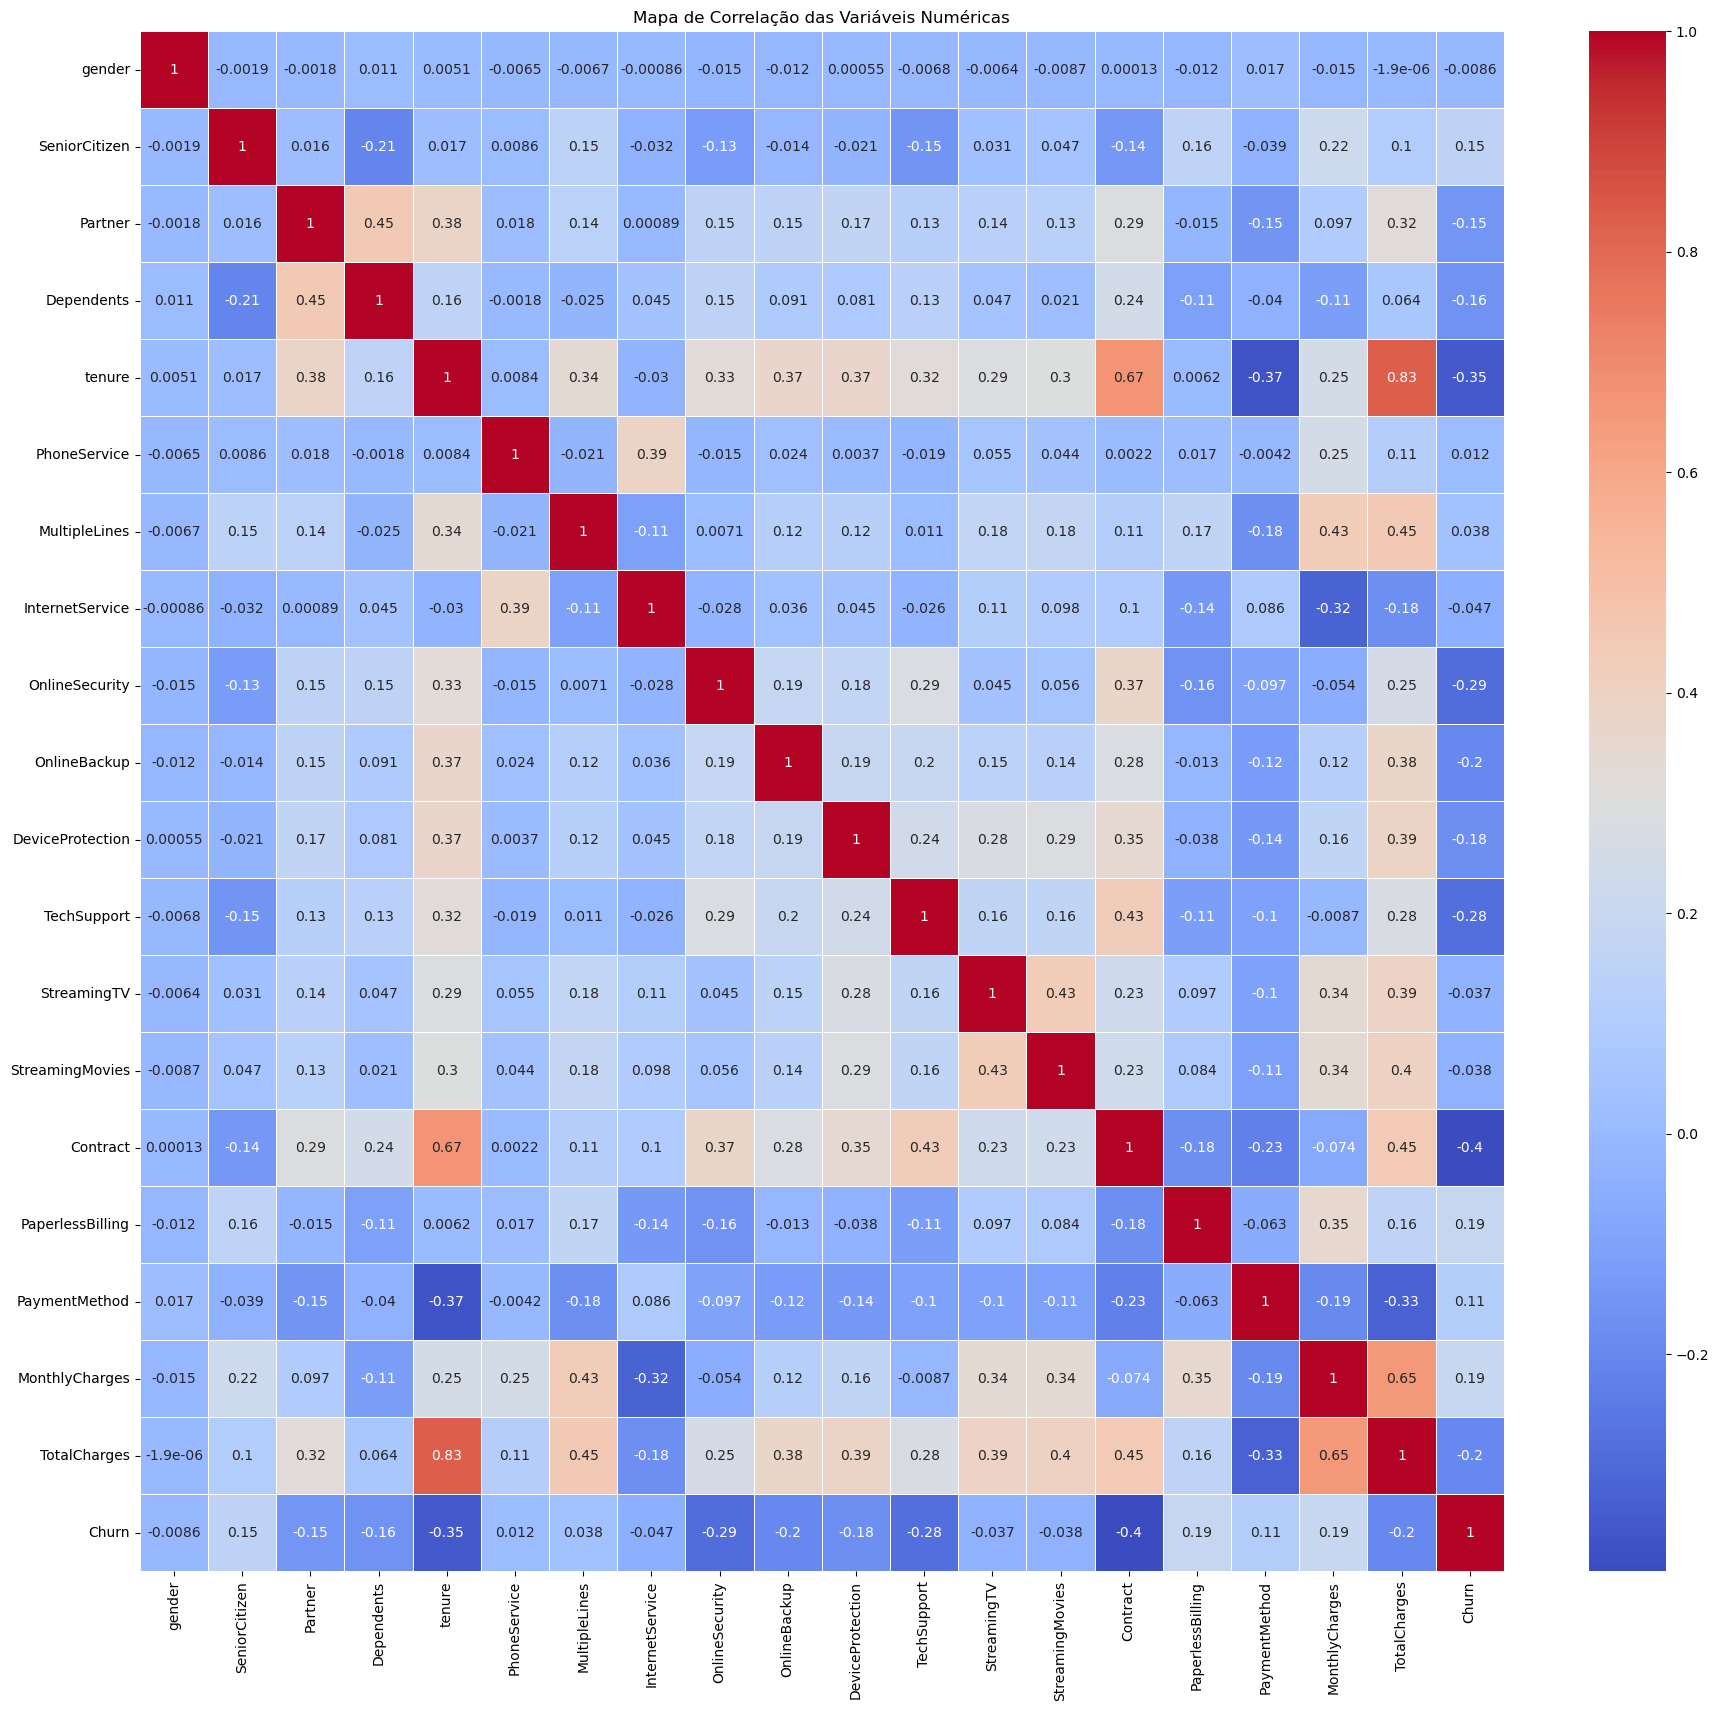

In [13]:
# Visualize the correlation between numerical variables
numerical_data = data.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(22, 20))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)

# Adjust the tick labels to ensure they are readable
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Keep y-axis labels horizontal

plt.title('Mapa de Correlação das Variáveis Numéricas')
plt.show()

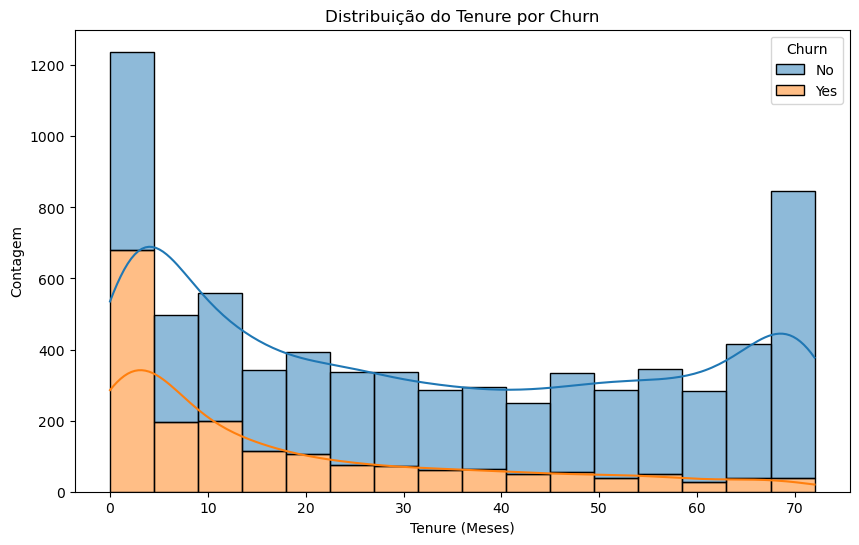

In [7]:
# Visualize the distribution of Tenure (length of stay) by Churn
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='tenure', hue='Churn', kde=True, multiple='stack')
plt.title('Distribuição do Tenure por Churn')
plt.xlabel('Tenure (Meses)')
plt.ylabel('Contagem')
plt.show()

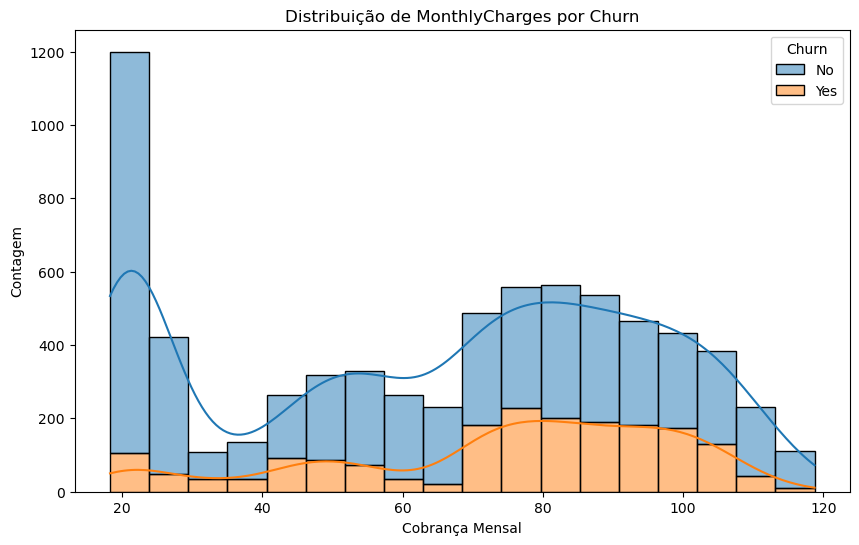

In [8]:
# Visualize the distribution of MonthlyCharges by Churn
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='MonthlyCharges', hue='Churn', kde=True, multiple='stack')
plt.title('Distribuição de MonthlyCharges por Churn')
plt.xlabel('Cobrança Mensal')
plt.ylabel('Contagem')
plt.show()

## Data Normalization

In [9]:
# Handle missing values in the TotalCharges column
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

# Remove customerID column
data = data.drop('customerID', axis=1)

# Encoding categorical variables
label_enc = LabelEncoder()
data['Churn'] = label_enc.fit_transform(data['Churn'])
for column in data.select_dtypes(include=['object']).columns:
    data[column] = label_enc.fit_transform(data[column])

# Normalize numerical variables
scaler = StandardScaler()
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

## Models

In [10]:
# Prepare data to models

# Set the seed for reproducibility
np.random.seed(42)

# Separate independent and dependent variables
X = data.drop('Churn', axis=1)
y = data['Churn']

# Apply SMOTE to balance the data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


In [11]:
# Models

# Dictionary to store the results
results = {}

# Models list
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Store the results
    results[model_name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    }

# Display the results in the form of a DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

                        Accuracy  Precision    Recall  F1 Score       AUC
Logistic Regression     0.790338   0.753749  0.853690  0.800613  0.873609
Random Forest           0.839936   0.817178  0.870020  0.842771  0.915299
Support Vector Machine  0.806763   0.771429  0.864141  0.815157  0.880632
Gradient Boosting       0.813527   0.776423  0.873285  0.822010  0.895733


## SHAP

In [12]:
# # SHAP for Random Forest
# best_rf = RandomForestClassifier()
# best_rf.fit(X_train, y_train)

# # Calculate SHAP values
# explainer = shap.TreeExplainer(best_rf)
# shap_values = explainer.shap_values(X_test)

# # Check if the problem is binary (two classes)
# if isinstance(shap_values, list):
#     shap_values = shap_values[1]  # Select the explanation for the "churn" class (class 1)

# # Display SHAP summary plot
# shap.summary_plot(shap_values, X_test, feature_names=X.columns)